Normalizando vocabulário oficial do CENIPA...
Vocabulário carregado: 84 termos únicos normalizados.
Carregando resultados de: results\cenipa_gemini_results.json...
Tabelas salvas em 'resultsmetrics'
Gráfico salvo em: resultsmetrics\comparacao_modelos.png


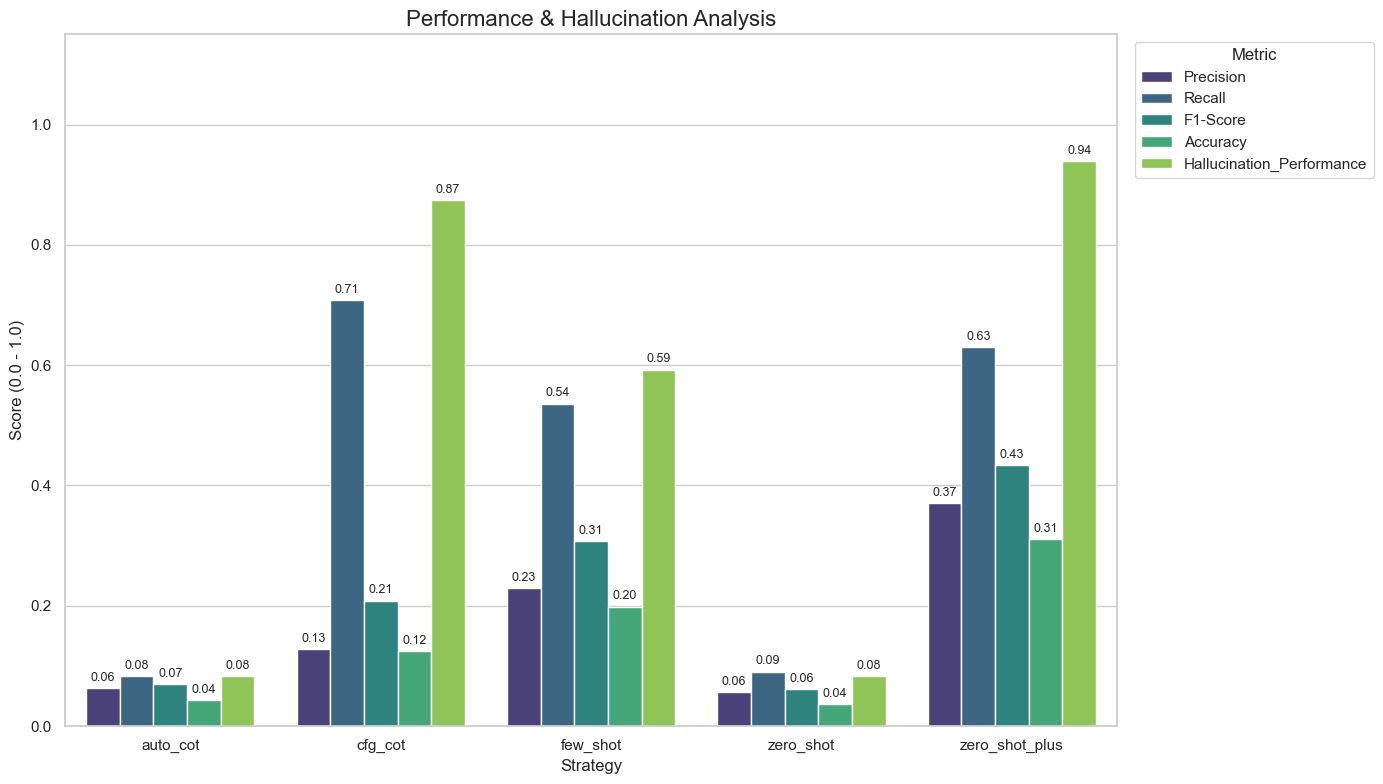

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
import re
import numpy as np
from pathlib import Path

# ==============================================================================
# CONFIGURAÇÕES E DADOS GLOBAIS
# ==============================================================================
INPUT_FILE = Path('results/cenipa_gemini_results.json')
OUTPUT_DIR = Path('resultsmetrics')
OUTPUT_IMG = OUTPUT_DIR / 'comparacao_modelos.png'
OUTPUT_METRICS_CSV = OUTPUT_DIR / 'tabela_metricas.csv'
OUTPUT_DEBUG_CSV = OUTPUT_DIR / 'debug_comparacao_fatores.csv'

# --- INSIRA AQUI OS SEUS 84 RÓTULOS DO CENIPA ---
# Estou colocando alguns exemplos. Substitua pela lista completa.
CENIPA_VOCABULARY_RAW = [
        "Álcool", "Ansiedade", "Atenção", "Atitude", "Capacitação e treinamento",  "Características da tarefa", "Clima organizacional",
        "Comunicação", "Condições físicas do trabalho", "Cultura do grupo de trabalho", "Cultura organizacional", "Desorientação", "Dieta inadequada",
        "Dinâmica da equipe", "Disbarismo", "Dor", "Enfermidade", "Enjoo aéreo", "Equipamento - características ergonômicas", "Estado emocional", "Fadiga",
        "Gravidez", "Hiperventilação", "Hipóxia", "Ilusões visuais", "Inconsciência", "Influências externas", "Insônia", "Intoxicação alimentar",
        "Intoxicação por CO", "Memória", "Motivação", "Obesidade", "Organização do trabalho", "Percepção", "Processo decisório", "Processos Organizacionais",
        "Próteses", "Relações interpessoais", "Ressaca", "Sistemas de apoio", "Sobrecarga de tarefas", "Uso de Medicamento", "Uso ilícito de drogas", "Vertigem",
        "Vestimenta inadequada", "Aplicação do comando", "Condições meteorológicas adversas", "Conhecimento de normas (ATS)", "Console (ATS)", "Coordenação de cabine",
        "Coordenação de tráfego (ATS)", "Desvio de navegação", "Emprego de meios (ATS)", "Equipamento de apoio (ATS)", "Fraseologia da tripulação",
        "Fraseologia do Órgão ATS", "Habilidade de controle (ATS)", "Indisciplina de voo", "Infraestrutura aeroportuária", "Instrução",
        "Julgamento de pilotagem", "Limite de autorização", "Manutenção da aeronave", "Outro", "Pessoal de apoio", "Planejamento de tráfego (ATS)",
        "Planejamento do voo", "Planejamento gerencial", "Pouca experiência do piloto", "Presença de ave", "Presença de fauna (não ave)", "Publicações (ATS)",
        "RADAR (ATS)", "Serviço fixo (ATS)", "Serviço móvel (ATS)", "Substituição na posição (ATS)", "Supervisão (ATS)", "Supervisão gerencial",
        "Tratamento (ATS)", "Visualização (ATS)", "Fabricação", "Manuseio do material", "Projeto"
]

# ==============================================================================
# FUNÇÕES DE NORMALIZAÇÃO AVANÇADA
# ==============================================================================

def singularizar_texto(texto):
    """
    Aplica regras de singularização.
    IMPORTANTE: Assume que o texto já está sem acentos (normalizado).
    """
    if not isinstance(texto, str): return ""

    palavras = texto.split()
    palavras_singulares = []

    # Lista de exceções (sem acentos)
    excecoes = {'onibus', 'lapis', 'cais', 'mes', 'gas', 'pais', 'simples', 'atras', 'apos', 'atraves', 'ferias'}

    for p in palavras:
        if p in excecoes:
            pass
        # Regras adaptadas para texto sem acento
        elif p.endswith('ns'): # jovens -> jovem
            p = p[:-2] + 'm'
        elif p.endswith('res'): # fatores -> fator
            p = p[:-2]
        elif p.endswith('zes'): # vezes -> vez
            p = p[:-2] + 'z'
        elif p.endswith('oes'): # condicoes -> condicao
            p = p[:-3] + 'ao'
        elif p.endswith('ais'): # locais -> local
            p = p[:-3] + 'al'
        elif p.endswith('eis'): # papeis -> papel (serve para éis e eis)
            p = p[:-3] + 'el'
        elif p.endswith('s') and not p.endswith('ss'): # humanos -> humano
            p = p[:-1]

        palavras_singulares.append(p)

    return " ".join(palavras_singulares)

def padronizar_frases(texto):
    """
    Realiza substituições de termos específicos.
    O texto de entrada já estará sem acentos e singularizado (ex: "condicao").
    """
    correcoes = {
        # Erros de singularização corrigidos ou mapeamentos diretos
        "aplicacao de comando": "aplicacao do comando",
        "aplicacao no comando": "aplicacao do comando",
        "manutencao de aeronave": "manutencao da aeronave",
        "planejamento de voo": "planejamento do voo",
        "condicao meteorologica adversa": "condicoes meteorologicas adversas", # Mapeia para o termo oficial
        "condicoes meteorologicas adversa": "condicoes meteorologicas adversas",
        "fator humano": "fatores humanos"
    }

    for errado, correto in correcoes.items():
        if errado in texto:
            texto = texto.replace(errado, correto)

    return texto

def normalize_text(text):
    """
    Pipeline completo de normalização.
    """
    if not isinstance(text, str):
        return ""

    # 1. Remove acentos (Normalização NFD)
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode('utf-8')

    # 2. Lowercase e strip
    text = text.lower().strip()

    # 3. Singularização (Agora adaptada para sem acentos)
    text = singularizar_texto(text)

    # 4. Padronização de frases
    text = padronizar_frases(text)

    return text

def extract_factors_from_response(response_text):
    if not response_text:
        return []

    # Remove cabeçalhos comuns
    clean_text = re.sub(r'(humanos|operacionais|materiais|fatores contribuintes):', '', response_text, flags=re.IGNORECASE)

    # Remove marcadores
    clean_text = clean_text.replace('*', '').replace('-', '')

    # Divide o texto
    clean_text = clean_text.replace('\n', ',')

    # Split e normalização
    items = [normalize_text(item) for item in clean_text.split(',') if item.strip()]

    # Remove itens muito curtos
    items = [item for item in items if len(item) > 2]

    return sorted(list(set(items)))

# ==============================================================================
# CÁLCULO DE MÉTRICAS (COM HALLUCINATION PERFORMANCE)
# ==============================================================================

def calculate_set_metrics(y_true, y_pred, official_vocab_set):
    """
    Calcula métricas de conjunto e a nova métrica de performance de alucinação.
    """
    # Normalizar o gabarito do acidente atual
    set_true = set([normalize_text(t) for t in y_true])
    set_pred = set(y_pred)

    # Interseção (Verdadeiros Positivos de Fatores)
    intersection = set_true.intersection(set_pred)
    len_intersection = len(intersection)

    # --- Métricas Clássicas ---
    precision = len_intersection / len(set_pred) if len(set_pred) > 0 else 0.0
    recall = len_intersection / len(set_true) if len(set_true) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    union = len(set_true.union(set_pred))
    accuracy = len_intersection / union if union > 0 else 0.0

    # --- Hallucination Performance (HP) ---
    # Verifica quantos dos preditos estão no VOCABULÁRIO OFICIAL DO CENIPA
    # Se o modelo prevê algo que existe no CENIPA (mesmo que errado para o acidente),
    # não é alucinação de domínio.

    if len(set_pred) == 0:
        # Se não previu nada, tecnicamente não alucinou. Performance é 100% (1.0).
        hallucination_perf = 1.0
        in_vocab_count = 0
    else:
        # Interseção entre o Predito e a Lista Oficial de 84 fatores
        pred_in_vocab = set_pred.intersection(official_vocab_set)
        in_vocab_count = len(pred_in_vocab)
        hallucination_perf = in_vocab_count / len(set_pred)

    return {
        "metrics": {
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1,
            "Accuracy": accuracy,
            "Hallucination_Performance": hallucination_perf
        },
        "debug_info": {
            "True_Set": sorted(list(set_true)),
            "Pred_Set": sorted(list(set_pred)),
            "Intersection": sorted(list(intersection)),
            "Terms_In_Taxonomy_Count": in_vocab_count,
            "Total_Preds": len(set_pred)
        }
    }

# ==============================================================================
# LOOP PRINCIPAL
# ==============================================================================

def main():
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

    if not INPUT_FILE.exists():
        print(f"Arquivo não encontrado: {INPUT_FILE}")
        return

    # 1. Preparar o Vocabulário Oficial (Normalizar uma única vez)
    print("Normalizando vocabulário oficial do CENIPA...")
    official_vocab_set = set([normalize_text(term) for term in CENIPA_VOCABULARY_RAW])
    print(f"Vocabulário carregado: {len(official_vocab_set)} termos únicos normalizados.")

    print(f"Carregando resultados de: {INPUT_FILE}...")
    with open(INPUT_FILE, 'r', encoding='utf-8') as f:
        data = json.load(f)

    metrics_results = []
    debug_data = []

    strategies = list(data[0]['respostas'].keys())

    for entry in data:
        arquivo = entry['arquivo']
        ground_truth = entry['ground_truth']

        for strat in strategies:
            raw_response = entry['respostas'].get(strat, "")

            pred_factors = extract_factors_from_response(raw_response)

            # Passamos agora o official_vocab_set
            result = calculate_set_metrics(ground_truth, pred_factors, official_vocab_set)

            metrics = result['metrics']
            debug_info = result['debug_info']

            metrics_results.append({
                "Arquivo": arquivo,
                "Estratégia": strat,
                **metrics
            })

            # Debug detalhado
            # Identificar quais termos foram considerados alucinação (fora do vocabulário)
            set_pred = set(debug_info['Pred_Set'])
            hallucinated_terms = list(set_pred - official_vocab_set)

            debug_data.append({
                "Arquivo": arquivo,
                "Estratégia": strat,
                "Raw_Response": raw_response[:50] + "...",
                "Ground_Truth": " | ".join(debug_info['True_Set']),
                "Prediction": " | ".join(debug_info['Pred_Set']),
                "Precision": round(metrics['Precision'], 2),
                "F1": round(metrics['F1-Score'], 2),
                "Hallucination_Perf": round(metrics['Hallucination_Performance'], 2),
                "Termos_Alucinados": " | ".join(hallucinated_terms) # Mostra o que o modelo inventou
            })

    # --- Salvar CSVs ---
    df_metrics = pd.DataFrame(metrics_results)
    df_metrics.to_csv(OUTPUT_METRICS_CSV, index=False)

    df_debug = pd.DataFrame(debug_data)
    df_debug.to_csv(OUTPUT_DEBUG_CSV, index=False, sep=';', encoding='utf-8-sig')

    print(f"Tabelas salvas em '{OUTPUT_DIR}'")

    # --- Visualização (EM INGLÊS) ---
    # 1. Agrupar e calcular média
    cols_to_plot = ['Precision', 'Recall', 'F1-Score', 'Accuracy', 'Hallucination_Performance']
    df_summary = df_metrics.groupby('Estratégia')[cols_to_plot].mean().reset_index()

    # 2. Renomear colunas para Inglês para o gráfico (Hallucination já está em inglês)
    df_summary = df_summary.rename(columns={'Estratégia': 'Strategy'})

    # 3. Derreter (Melt) para formato longo
    df_melted = df_summary.melt(id_vars="Strategy", var_name="Metric", value_name="Score")

    plt.figure(figsize=(14, 8)) # Aumentei um pouco a largura
    sns.set_theme(style="whitegrid")

    # Plotagem
    chart = sns.barplot(data=df_melted, x="Strategy", y="Score", hue="Metric", palette="viridis")

    plt.title('Performance & Hallucination Analysis', fontsize=16)
    plt.ylabel('Score (0.0 - 1.0)', fontsize=12)
    plt.xlabel('Strategy', fontsize=12)
    plt.ylim(0, 1.15) # Mais espaço para a legenda

    plt.legend(title='Metric', bbox_to_anchor=(1.01, 1), loc='upper left')

    for container in chart.containers:
        chart.bar_label(container, fmt='%.2f', padding=3, fontsize=9)

    plt.tight_layout()
    plt.savefig(OUTPUT_IMG, dpi=300)
    print(f"Gráfico salvo em: {OUTPUT_IMG}")

if __name__ == "__main__":
    main()